In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer

import operator
from functools import reduce, partial

#################################################
#
# Utilities
#
#################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float


# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001, time_last=True):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T in 1D
        # x could be in shape of ntrain*w*l or ntrain*T*w*l or ntrain*w*l*T in 2D
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps
        self.time_last = time_last  # if the time dimension is the last dim

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        # sample_idx is the spatial sampling mask
        if sample_idx is None:
            std = self.std + self.eps  # n
            mean = self.mean
        else:
            if self.mean.ndim == sample_idx.ndim or self.time_last:
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if self.mean.ndim > sample_idx.ndim and not self.time_last:
                std = self.std[..., sample_idx] + self.eps  # T*batch*n
                mean = self.mean[..., sample_idx]
        # x is in shape of batch*(spatial discretization size) or T*batch*(spatial discretization size)
        x = (x * std) + mean
        return x

    def to(self, device):
        if torch.is_tensor(self.mean):
            self.mean = self.mean.to(device)
            self.std = self.std.to(device)
        else:
            self.mean = torch.from_numpy(self.mean).to(device)
            self.std = torch.from_numpy(self.std).to(device)
        return self

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h ** (self.d / self.p)) * torch.norm(
            x.view(num_examples, -1) - y.view(num_examples, -1), self.p, 1
        )

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)

        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2,) if p.is_complex() else p.size()))
    return c

In [2]:
torch.manual_seed(0)
np.random.seed(0)


################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-2),
            x.size(-1) // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO2d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.padding = 9  # pad the domain if input is non-periodic
        self.fdepth = len(modes)

        self.p = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        self.convs = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, mode, mode) for mode in self.modes]
        )
        self.ws = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.fdepth)]
        )
        self.q = MLP(self.width, 1, self.width * 4)  # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0, self.padding, 0, self.padding])

        for i in range(self.fdepth):
            x1 = self.convs[i](x)
            x2 = self.ws[i](x)
            x = x1 + x2
            if i != 3:
                x = F.gelu(x)

        x = x[..., : -self.padding, : -self.padding]
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])

        return torch.cat((gridx, gridy), dim=-1).to(device)

In [3]:
################################################################
# configs
################################################################
NTRAIN = 1000
NTEST = 100

BATCH_SIZE = 20
LEARNING_RATE = 0.001
EPOCHS = 500
ITERATIONS = EPOCHS * (NTRAIN // BATCH_SIZE)

# MODES = 12
WIDTH = 32

R = 5
H = int(((421 - 1) / R) + 1)
S = H

PAR_PATH = "/kaggle/input/" if "kaggle" in os.getcwd() else "./"

TRAIN_PATH = PAR_PATH + "darcy421/piececonst_r421_N1024_smooth1.mat"
TEST_PATH = PAR_PATH + "darcy421/piececonst_r421_N1024_smooth2.mat"

In [4]:
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
x_train = reader.read_field("coeff")[:NTRAIN, ::R, ::R][:, :S, :S]
y_train = reader.read_field("sol")[:NTRAIN, ::R, ::R][:, :S, :S]

reader.load_file(TEST_PATH)
x_test = reader.read_field("coeff")[:NTEST, ::R, ::R][:, :S, :S]
y_test = reader.read_field("sol")[:NTEST, ::R, ::R][:, :S, :S]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(NTRAIN, S, S, 1)
x_test = x_test.reshape(NTEST, S, S, 1)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test), batch_size=BATCH_SIZE, shuffle=False
)

In [5]:
################################################################
# model
################################################################
resolution = x_train.shape[1] // 2 + 1
max_mode = 2 * resolution // 3
modes = np.array([8, 16, max_mode, 16, 8])
model = FNO2d(modes, WIDTH).cuda()
print(count_params(model))

5842465


In [6]:
################################################################
# training and evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ITERATIONS)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()

train_losses = []
test_losses = []

for ep in range(EPOCHS):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(BATCH_SIZE, S, S)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(BATCH_SIZE, -1), y.view(BATCH_SIZE, -1))
        loss.backward()

        optimizer.step()
        scheduler.step()
        train_l2 += loss.item()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(BATCH_SIZE, S, S)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(BATCH_SIZE, -1), y.view(BATCH_SIZE, -1)).item()

    train_l2 /= NTRAIN
    test_l2 /= NTEST

    train_losses.append(train_l2)
    test_losses.append(test_l2)

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

torch.save(model.state_dict(), "./model_darcy_weights.pth")
np.savez("darcy_train_losses.npz", train_losses, test_losses)

0 3.885661457999987 0.16344916534423828 0.11313683271408081
1 2.4714859219999994 0.10036202001571655 0.09536622643470764
2 2.492329395000013 0.07339005923271179 0.06232709288597107
3 2.473813911999997 0.051336840629577635 0.0457883495092392
4 2.4683933650000256 0.03995506852865219 0.037198628783226016
5 2.464758040000021 0.031914414644241336 0.030602893829345702
6 2.468763960999979 0.030061390578746797 0.028015032410621643
7 2.46101935599998 0.025549062877893446 0.02892010271549225
8 2.4561004439999863 0.023607180505990984 0.026151449978351594
9 2.457838707999997 0.022595838278532027 0.0258949014544487
10 2.4615790440000183 0.019941194355487822 0.021479578316211702
11 2.459152439999997 0.018252736270427703 0.022913199663162232
12 2.46146988000001 0.01857118174433708 0.02042601853609085
13 2.4629451899999992 0.016785054981708528 0.02389315187931061
14 2.465418449999987 0.017705584973096846 0.020289942920207978
15 2.4839469259999873 0.01725649404525757 0.023146489262580873
16 2.461191778

# Show results


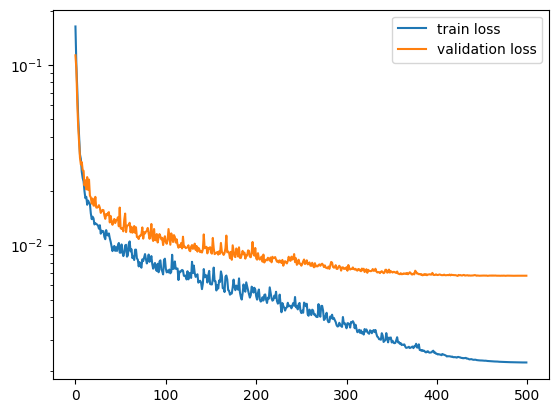

In [13]:
plt.figure()
plt.semilogy(train_losses, label="train loss")
plt.semilogy(test_losses, label="validation loss")
plt.legend()
plt.show()

# Tests


In [8]:
NVAL = 2

# model = FNO2d(MODES, MODES, WIDTH).to(device)
# model.load_state_dict(
#     torch.load("./model_darcy_weights_ep500.pth", map_location=device)
# )
model.eval()

FNO2d(
  (p): Linear(in_features=3, out_features=32, bias=True)
  (convs): ModuleList(
    (0-4): 5 x SpectralConv2d()
  )
  (ws): ModuleList(
    (0-4): 5 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (q): MLP(
    (mlp1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [9]:
reader = MatReader(TEST_PATH)
x_val = reader.read_field("coeff")[:NVAL, ::R, ::R][:, :S, :S]
y_val = reader.read_field("sol")[:NVAL, ::R, ::R][:, :S, :S]

x_normalizer = UnitGaussianNormalizer(x_val)
x_val = x_normalizer.encode(x_val)

y_normalizer = UnitGaussianNormalizer(y_val)
y_val = y_normalizer.encode(y_val)

x_val = x_val.reshape(NVAL, S, S, 1)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val, y_val), batch_size=1, shuffle=False
)

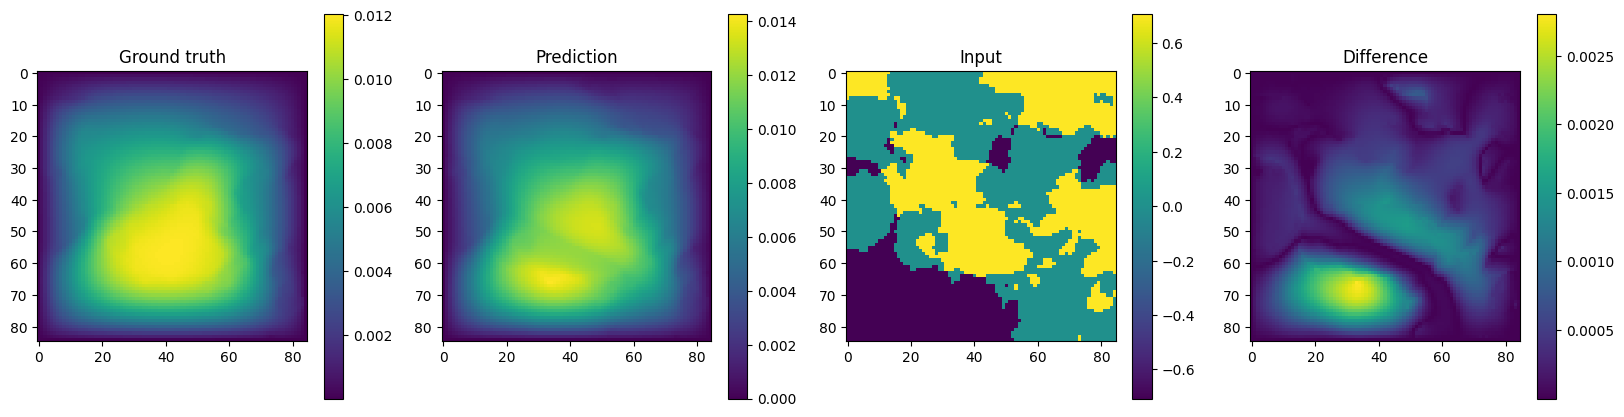

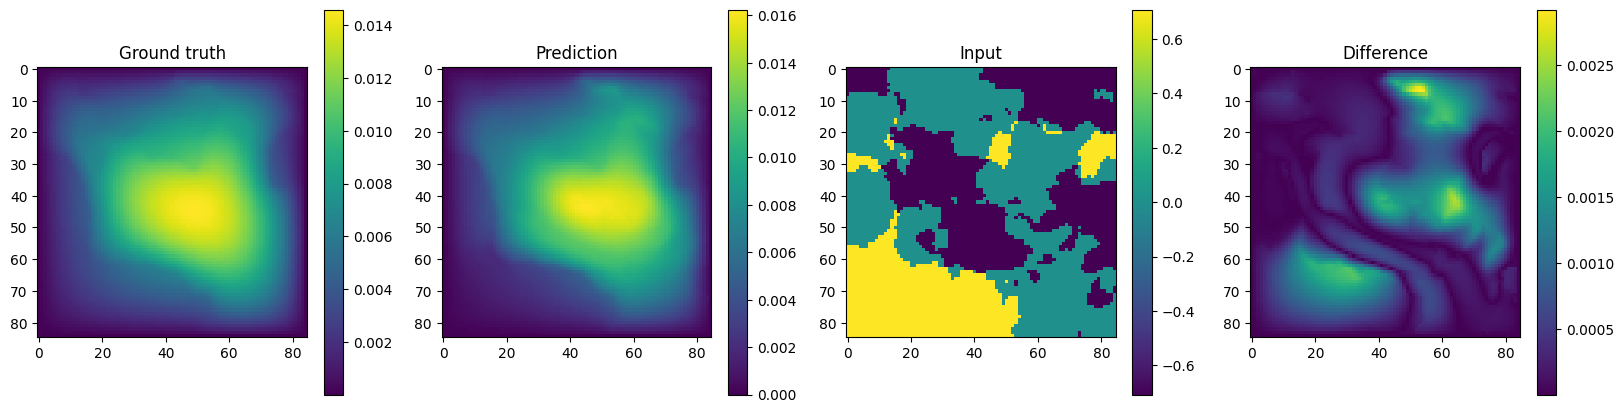

In [10]:
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        out = model(x).reshape(1, S, S)
        out = y_normalizer.decode(out.cpu())
        y = y_normalizer.decode(y.cpu())

        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        y_test = y[0].cpu().detach().numpy().reshape(S, S)
        plt.imshow(y_test)
        plt.colorbar()
        plt.title("Ground truth")

        plt.subplot(1, 4, 2)
        pred_test = out[0].cpu().detach().numpy().reshape(S, S)
        plt.imshow(pred_test)
        plt.colorbar()
        plt.title("Prediction")

        plt.subplot(1, 4, 3)
        plt.imshow(x[0].cpu().detach().numpy().reshape(S, S))
        plt.title("Input")
        plt.colorbar()

        plt.subplot(1, 4, 4)
        plt.imshow(np.abs(y_test - pred_test))
        plt.colorbar()
        plt.title("Difference")
        plt.savefig("Example.png")
        plt.show()

In [11]:
losses = np.load("darcy_train_losses.npz")
train_losses, test_losses = losses["train_losses"], losses["test_losses"]

plt.figure()
plt.semilogy(train_losses, label="train loss")
plt.semilogy(test_losses, label="test loss")
plt.legend()
plt.show()

KeyError: 'train_losses is not a file in the archive'